# COVID19 SIR Model

## Goal 
Before, we had used a logistic model to predict the trajectory of the COVID19 Virus. This however, has many drawbacks:

* Not enough factors are included (Social Distancing, Mobility between communities, etc.)
* Not enough categories: doesn't give us more info than how many cases we're expected to have
* Ill posed: Slight peturbations in sample data can lead to a drastic change in predicted data

There exists a better approach to this, and it is called the SIR/SEIR (Susceptible, Exposed, Infected, Removed) model. This is a system of differential equations.

## The SIR Model
For simplicity's sake, we'll start with the SIR model:
$$\frac{dS}{dt}=-\beta*I*\frac{S}{N}$$
$$\frac{dI}{dt}=\beta*I*\frac{S}{N}-\gamma*I$$
$$\frac{dR}{dt}=\gamma*I$$
$$N=S+I+R$$

### Fetching the Data
Like the logistic fit, we'll gather data from JHU CSSE (Johns Hopkins University). Then, we can get the needed plots for an SIR/SEIR Analysis.

* https://github.com/CSSEGISandData/COVID-19
* https://github.com/pomber/covid19

In [1]:
"""
@author Vikram Ramavarapu
"""

import requests

r = requests.get('https://pomber.github.io/covid19/timeseries.json')
json_data = r.json()

#This should print the number of confirmed cases in Thailand in January 22, 2020 
print(json_data['Thailand'][0]['confirmed'])

2


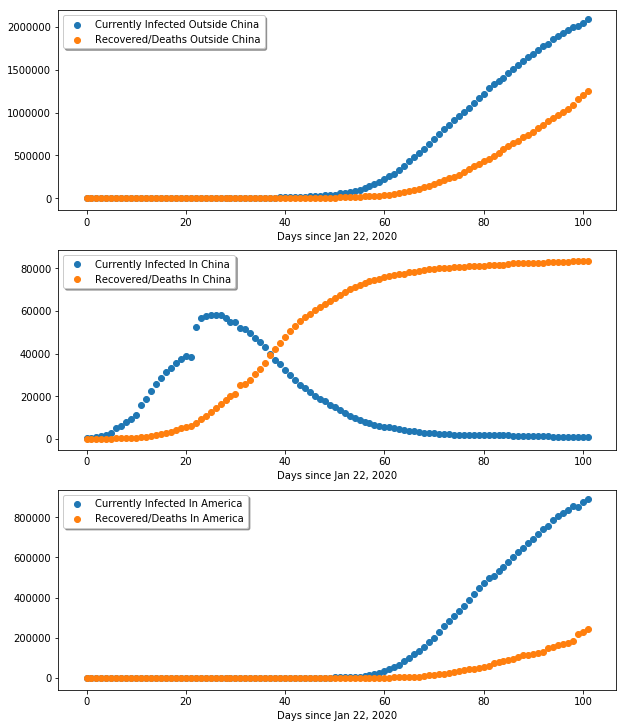

In [2]:
import matplotlib.pyplot as plt
import matplotlib.axes as axis

"""
@param date_index the given number of days past Jan 22, 2020
@return worldwide number of infections on that given day
"""
def worldwide_i(date_index):
    infected = 0
    
    #loop through every country that isnt china and get (confirmed cases - (deaths+recoveries))
    for key in json_data:
        if (key != 'China'):
            infected = infected + (json_data[key][date_index]['confirmed'] - (json_data[key][date_index]['deaths'] + json_data[key][date_index]['recovered']))
    return infected

"""
@param date_index the given number of days past Jan 22, 2020
@return worldwide number of removed (i.e. deaths + recoveries) on that given day
"""
def worldwide_r(date_index):
    removed = 0
    for key in json_data:
        if (key != 'China'):
            removed = removed + (json_data[key][date_index]['deaths'] + json_data[key][date_index]['recovered'])
    return removed

#fill an array where the index is the days past Jan 22, 2020 and the value is the number of infections on that day
currently_infected_outside = []
for i in range(len(json_data['China'])):
    currently_infected_outside.append(worldwide_i(i))

#fill an array where the index is the days past Jan 22, 2020 and the value is the number of removed on that day
removed_outside = []
for i in range(len(json_data['China'])):
    removed_outside.append(worldwide_r(i))

#plot worldwide data
fig, axs = plt.subplots(3, 1, figsize=(10, 12.5))

axs[0].scatter(range(len(json_data['China'])), currently_infected_outside, label='Currently Infected Outside China')
axs[0].scatter(range(len(json_data['China'])), removed_outside, label='Recovered/Deaths Outside China')
axs[0].set_xlabel('Days since Jan 22, 2020')
axs[0].legend(shadow=True, fancybox=True)

"""
@param country the name of the country specified
@param date_index the given number of days past Jan 22, 2020
@return worldwide number of infections/removed on that given day in that given country
"""
def country_i(country, date_index):
    infected = json_data[country][date_index]['confirmed'] - (json_data[country][date_index]['deaths'] + json_data[country][date_index]['recovered'])
    return infected

def country_r(country, date_index):
    removed = (json_data[country][date_index]['deaths'] + json_data[country][date_index]['recovered'])
    return removed

#Fill the arrays of infected an removed for China and US
currently_infected_china = []
for i in range(len(json_data['China'])):
    currently_infected_china.append(country_i('China', i))
    
removed_china = []
for i in range(len(json_data['China'])):
    removed_china.append(country_r('China', i))
    
currently_infected_us = []
for i in range(len(json_data['China'])):
    currently_infected_us.append(country_i('US', i))
    
removed_us = []
for i in range(len(json_data['China'])):
    removed_us.append(country_r('US', i))

#Plot the country data
axs[1].scatter(range(len(json_data['China'])), currently_infected_china, label='Currently Infected In China')
axs[1].scatter(range(len(json_data['China'])), removed_china, label='Recovered/Deaths In China')
axs[1].set_xlabel('Days since Jan 22, 2020')
axs[1].legend(shadow=True, fancybox=True)

axs[2].scatter(range(len(json_data['China'])), currently_infected_us, label='Currently Infected In America')
axs[2].scatter(range(len(json_data['China'])), removed_us, label='Recovered/Deaths In America')
axs[2].set_xlabel('Days since Jan 22, 2020')
axs[2].legend(shadow=True, fancybox=True)

plt.show()

### Solving Upwards
Based on this data, it looks like China is about completely through with their pandemic, so it seems like China will be a fair model as for the complete shape of both the $I$ and $R$ curves. Now, since we know the data set for $I$ and $R$ for our three cases, we can solve upward. First we solve for $\gamma$, our removed coefficient:

$$\frac{dR}{dt}\div I=\gamma\approx\frac{R(t)-R(t-1)}{I}$$

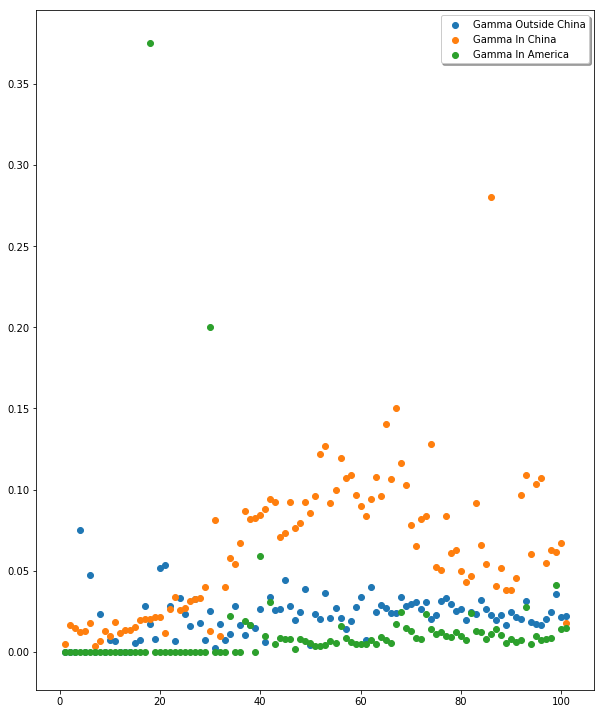

In [3]:
"""
@param date_index given number of days past Jan 22, 2020
@return gamma value on that given date index
"""
def world_gamma(date_index):
    infected = worldwide_i(date_index)
    change_removed = worldwide_r(date_index) - worldwide_r(date_index - 1)
    return change_removed/infected

def country_gamma(country, date_index):
    infected = country_i(country, date_index)
    change_removed = country_r(country, date_index) - country_r(country, date_index - 1)
    return change_removed/infected

#fill arrays via that function
worldwide_gammas = []
for i in range(1, len(json_data['China'])):
    worldwide_gammas.append(world_gamma(i))

china_gammas = []
for i in range(1, len(json_data['China'])):
    china_gammas.append(country_gamma('China', i))
    
us_gammas = []
for i in range(1, len(json_data['China'])):
    us_gammas.append(country_gamma('US', i))

#plot the scattered data
fig, ax = plt.subplots(1, 1, figsize=(10, 12.5))
ax.scatter(range(1, len(json_data['China'])), worldwide_gammas, label='Gamma Outside China')
ax.scatter(range(1, len(json_data['China'])), china_gammas, label='Gamma In China')
ax.scatter(range(1, len(json_data['China'])), us_gammas, label='Gamma In America')
ax.legend(shadow=True, fancybox=True)


As predicted, $\gamma$ changes over time. This is likely due to increases in social distancing, increased precautions taken in hospitals to treat patients. One thing we also need to consider is that with numbers going down, this doesn't necessarily mean the number of recoveries are slowing, it means that the death rate is going down. When we get into the SEIRD model, separating deaths and recoveries, predictions will then solidify. Now, since $\gamma$ isn't constant with time, then:

$$\gamma\notin\mathbb{R}$$, but $$\gamma(t):\mathbb{R}\rightarrow\mathbb{R}$$
Since this function has an unknown form, our best approximation is by using a higher degree polynomial, since essentially every function is expressable as a polynomial. Let our polynomials have degree $n=6$:

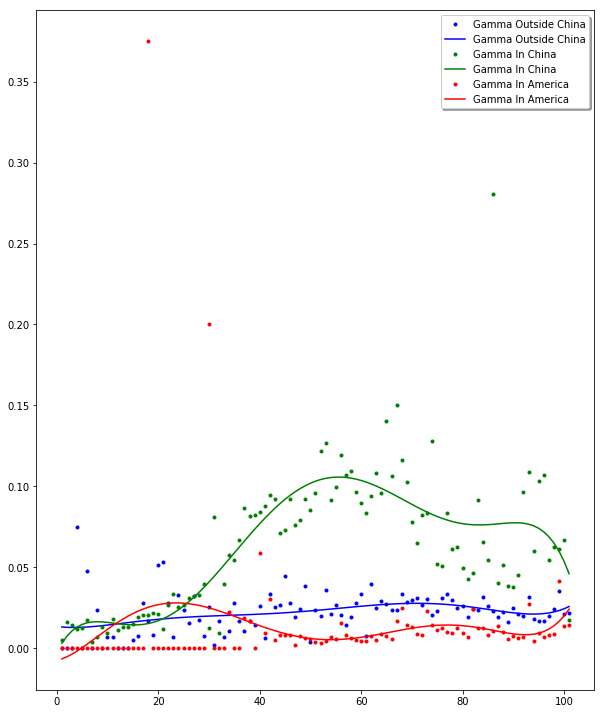

In [4]:
import numpy as np

x_vals = np.array(range(1, len(json_data['China'])))

#using numpy's polyfit, fit a 6th degree polynomial over the data

#gather coefficients of the polynomial
worldwide_gamma_coeffs = np.polyfit(x_vals, worldwide_gammas, 6)
china_gamma_coeffs = np.polyfit(x_vals, china_gammas, 6)
us_gamma_coeffs = np.polyfit(x_vals, us_gammas, 6)

#apply the coefficients
worldwide_gamma_fit = np.poly1d(worldwide_gamma_coeffs)
china_gamma_fit = np.poly1d(china_gamma_coeffs)
us_gamma_fit = np.poly1d(us_gamma_coeffs)

#Plot gamma fits
fig, ax = plt.subplots(1, 1, figsize=(10, 12.5))
ax.plot(range(1, len(json_data['China'])), worldwide_gammas, '.', x_vals, worldwide_gamma_fit(x_vals), '-', label='Gamma Outside China', color='b')
ax.plot(range(1, len(json_data['China'])), china_gammas, '.', x_vals, china_gamma_fit(x_vals), '-', label='Gamma In China', color='g')
ax.plot(range(1, len(json_data['China'])), us_gammas, '.', x_vals, us_gamma_fit(x_vals), '-', label='Gamma In America', color='r')
ax.legend(shadow=True, fancybox=True)


The worldwide and American progress through the pandemic is still very small, so a refined curve like the one in the Chinese fit. The idea is that we'll allow for any ifs and buts through a future interpolated curve. Now to solve for $\beta$. This means getting the susceptible population. Since, $N=S+I+R$, we need to find $N$. Since no one is known to be immune to COVID19, we set $N$ to the population of each community, so for $S$ we take that minus the number of cases. For each community we set:

$$N_{Worldwide}\sim6.4*10^{9}$$
$$N_{China}\sim1.4*10^9$$
$$N_{US}\sim3.3*10^7$$  
  
Using that we can get a dataset for the susceptible population:

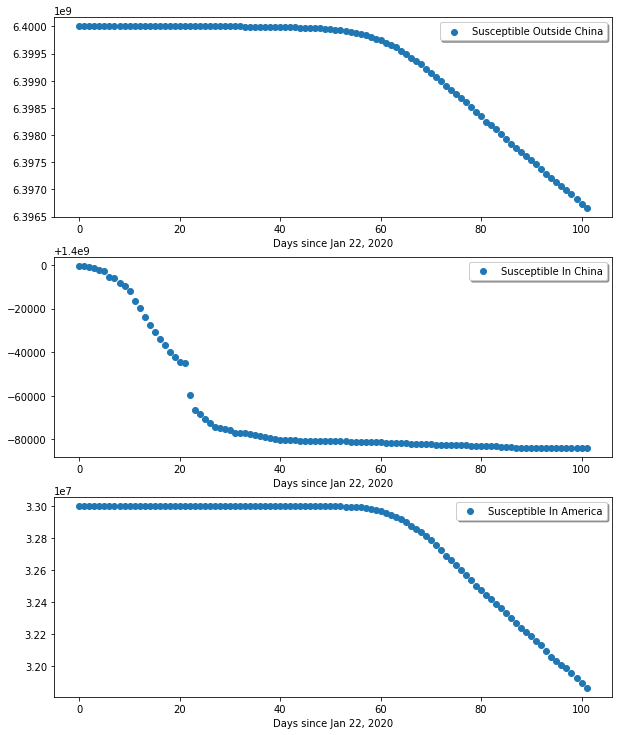

In [5]:
#populations
outside_pop = 6.4*10**9
china_pop = 1.4*10**9
us_pop = 3.3*10**7

"""
@param date_index given number of days past Jan 22, 2020
@return number of people susceptible to COVID19
"""
def worldwide_s(date_index):
    confirmed = 0
    for key in json_data:
        if key != 'China':
            confirmed = confirmed + json_data[key][date_index]['confirmed']
    return outside_pop - confirmed

def china_s(date_index):
    return china_pop - json_data['China'][date_index]['confirmed']

def us_s(date_index):
    return us_pop - json_data['US'][date_index]['confirmed']

#fill arrays with function values corresponding to the date indices
outside_susceptible = []
china_susceptible = []
us_susceptible = []

date_range = range(len(json_data['China']))

for i in date_range:
    outside_susceptible.append(worldwide_s(i))
    china_susceptible.append(china_s(i))
    us_susceptible.append(us_s(i))

#Plot the given data
fig, axs = plt.subplots(3, 1, figsize=(10, 12.5))

axs[0].scatter(date_range, outside_susceptible, label='Susceptible Outside China')
axs[0].set_xlabel('Days since Jan 22, 2020')
axs[0].legend(shadow=True, fancybox=True)    
axs[1].scatter(date_range, china_susceptible, label='Susceptible In China')
axs[1].set_xlabel('Days since Jan 22, 2020')
axs[1].legend(shadow=True, fancybox=True)
axs[2].scatter(date_range, us_susceptible, label='Susceptible In America')
axs[2].set_xlabel('Days since Jan 22, 2020')
axs[2].legend(shadow=True, fancybox=True)


Since we know the set of data for S, we can approximate $\beta(t)$ for each of our three cases by solving and setting:

$$\beta(t)=-\frac{dS}{dt}*\frac{N}{SI}\approx-[S(t)-S(t-1)]*\frac{N}{S(t)I}$$

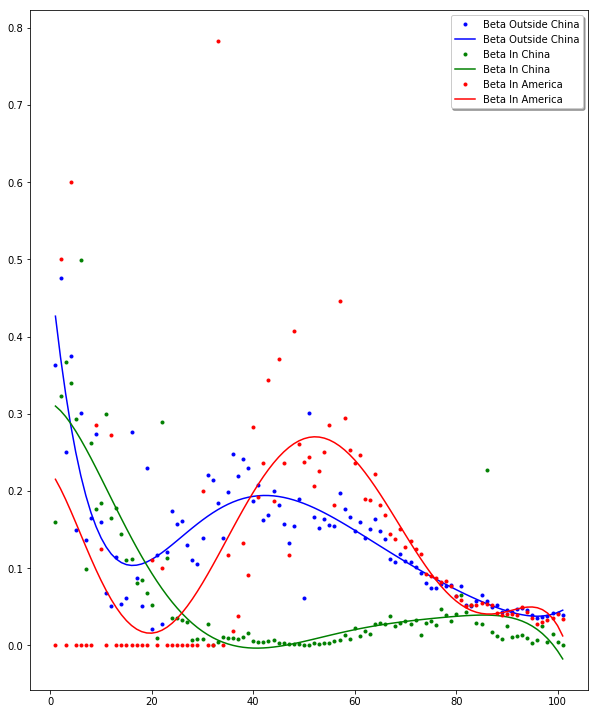

In [6]:
"""
@param date_index number of days past since Jan 22, 2020
@return beta value on that given day
"""
def world_beta(date_index):
    dS = worldwide_s(date_index)-worldwide_s(date_index - 1)
    return -dS*(outside_pop/(worldwide_s(date_index)*worldwide_i(date_index)))

def china_beta(date_index):
    dS = china_s(date_index)-china_s(date_index - 1)
    return -dS*(china_pop/(china_s(date_index)*country_i('China', date_index)))

def us_beta(date_index):
    dS = us_s(date_index)-us_s(date_index - 1)
    return -dS*(us_pop/(us_s(date_index)*country_i('US', date_index)))

#fills beta arrays using those functions
worldwide_betas = []
for i in range(1, len(json_data['China'])):
    worldwide_betas.append(world_beta(i))
    
china_betas = []
for i in range(1, len(json_data['China'])):
    china_betas.append(china_beta(i))
    
us_betas = []
for i in range(1, len(json_data['China'])):
    us_betas.append(us_beta(i))
    
#6th degree poly fit over beta values
worldwide_beta_coeffs = np.polyfit(x_vals, worldwide_betas, 6)
china_beta_coeffs = np.polyfit(x_vals, china_betas, 6)
us_beta_coeffs = np.polyfit(x_vals, us_betas, 6)

worldwide_beta_fit = np.poly1d(worldwide_beta_coeffs)
china_beta_fit = np.poly1d(china_beta_coeffs)
us_beta_fit = np.poly1d(us_beta_coeffs)

#plot beta fits
fig, ax = plt.subplots(1, 1, figsize=(10, 12.5))
ax.plot(range(1, len(json_data['China'])), worldwide_betas, '.', x_vals, worldwide_beta_fit(x_vals), '-', label='Beta Outside China', color='b')
ax.plot(range(1, len(json_data['China'])), china_betas, '.', x_vals, china_beta_fit(x_vals), '-', label='Beta In China', color='g')
ax.plot(range(1, len(json_data['China'])), us_betas, '.', x_vals, us_beta_fit(x_vals), '-', label='Beta In America', color='r')
ax.legend(shadow=True, fancybox=True)

Now that we have $\gamma(t)$ and $\beta(t)$, we can solve the system of differential equations cleanly with our given ICs. Remembering that the system is:

$$\frac{dS}{dt}=-\beta*I*\frac{S}{N}$$
$$\frac{dI}{dt}=\beta*I*\frac{S}{N}-\gamma*I$$
$$\frac{dR}{dt}=\gamma*I$$
$$N=S+I+R$$

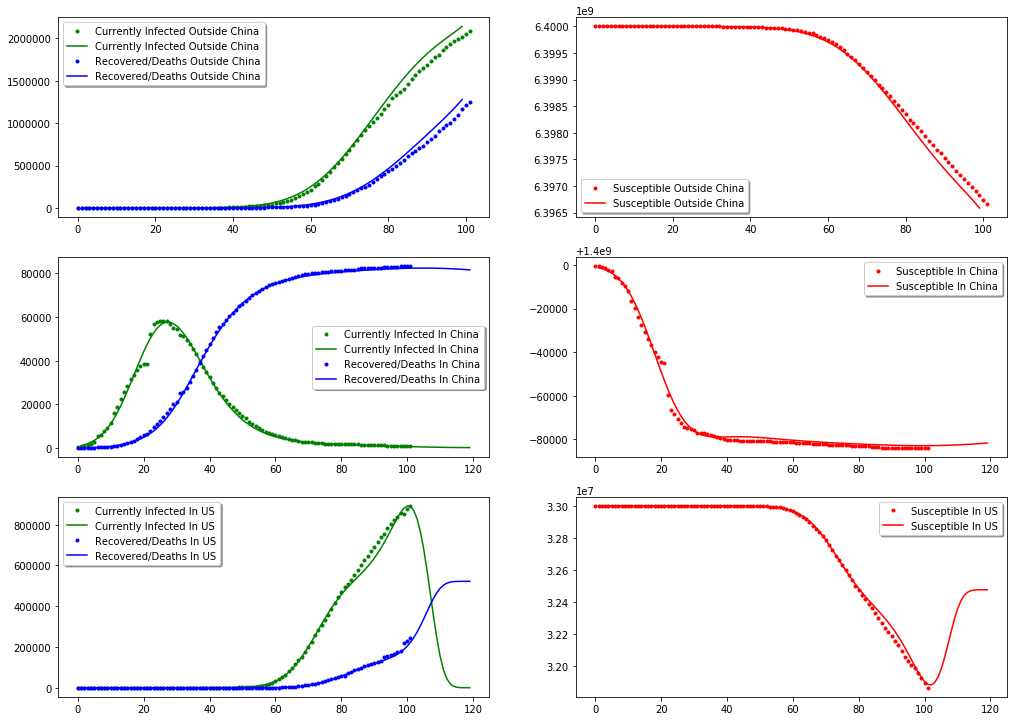

In [7]:
from scipy.integrate import odeint

"""
@params y=[S(t), I(t), R(t)]
@param N: const param of system
@returns [dS, dI, dR]
"""
def world_sir(y, t, N):
    return [
        -1 * worldwide_beta_fit(t) * y[1] * y[0] / N,
        worldwide_beta_fit(t) * y[1] * y[0] / N - worldwide_gamma_fit(t) * y[1],
        worldwide_gamma_fit(t)*y[1]
    ]

#ICs and params for worldwide system
worldwide_init, params = [worldwide_s(1), worldwide_i(1), worldwide_r(1)], (outside_pop,)

worldwide_odeint, info = odeint(world_sir, worldwide_init, range(1, 100), params, full_output=True)

worldwide_S_fit = []
worldwide_I_fit = []
worldwide_R_fit = []
for i in worldwide_odeint:
    worldwide_S_fit.append(i[0])
    worldwide_I_fit.append(i[1])
    worldwide_R_fit.append(i[2])

"""
IC was ambiguous (close to origin) so not much of a well fitted constant could be calculated.
This corrects this final constant based on our data
"""
#Take the 2-norms of both the actual and fitted data and then divide the magnitudes
I_norm = np.linalg.norm(currently_infected_outside, 2)
I_fit_norm = np.linalg.norm(worldwide_I_fit[:len(currently_infected_outside)], 2)
multiplier = I_norm/I_fit_norm

#multiply the magnitude by the fit to update the ambiguously calculated coefficient
for i in range(len(worldwide_I_fit)):
    worldwide_I_fit[i] = worldwide_I_fit[i] * multiplier

#Repeat for the R population
R_norm = np.linalg.norm(removed_outside, 2)
R_fit_norm = np.linalg.norm(worldwide_R_fit[:len(removed_outside)], 2)
multiplier = R_norm/R_fit_norm

for i in range(len(worldwide_R_fit)):
    worldwide_R_fit[i] = worldwide_R_fit[i] * multiplier
    worldwide_S_fit[i] = outside_pop - (worldwide_R_fit[i] + worldwide_I_fit[i])

#Plotting fits
fig, axs = plt.subplots(3, 2, figsize=(17, 12.5))
axs[0][0].plot(range(len(json_data['China'])), currently_infected_outside, '.', range(1, 100), worldwide_I_fit, '-', label='Currently Infected Outside China', color='g')
axs[0][0].plot(range(len(json_data['China'])), removed_outside, '.', range(1, 100), worldwide_R_fit, '-', label='Recovered/Deaths Outside China', color='b')
axs[0][0].legend(shadow=True, fancybox=True)

axs[0][1].plot(range(len(json_data['China'])), outside_susceptible, '.', range(1, 100), worldwide_S_fit, '-', label='Susceptible Outside China', color='r')
axs[0][1].legend(shadow=True, fancybox=True)

"""
Repeating this process for China
"""
def china_sir(y, t, N):
    return [
        -1 * china_beta_fit(t) * y[1] * y[0] / N,
        china_beta_fit(t) * y[1] * y[0] / N - china_gamma_fit(t) * y[1],
        china_gamma_fit(t)*y[1]
    ]

#ICs and params for worldwide system
china_init, params = [china_s(1), country_i('China', 1), country_r('China', 1)], (china_pop,)

china_odeint, info = odeint(china_sir, china_init, range(1, 120), params, full_output=True)

china_S_fit = []
china_I_fit = []
china_R_fit = []
for i in china_odeint:
    china_S_fit.append(i[0])
    china_I_fit.append(i[1])
    china_R_fit.append(i[2])

#fixing linear coeff
I_norm = np.linalg.norm(currently_infected_china, 2)
I_fit_norm = np.linalg.norm(china_I_fit[:len(currently_infected_china)], 2)
multiplier = I_norm/I_fit_norm

for i in range(len(china_I_fit)):
    china_I_fit[i] = china_I_fit[i] * multiplier

R_norm = np.linalg.norm(removed_china, 2)
R_fit_norm = np.linalg.norm(china_R_fit[:len(removed_china)], 2)
multiplier = R_norm/R_fit_norm

for i in range(len(china_R_fit)):
    china_R_fit[i] = china_R_fit[i] * multiplier
    china_S_fit[i] = china_pop - (china_R_fit[i] + china_I_fit[i])

#Plotting fits
axs[1][0].plot(range(len(json_data['China'])), currently_infected_china, '.', range(1, 120), china_I_fit, '-', label='Currently Infected In China', color='g')
axs[1][0].plot(range(len(json_data['China'])), removed_china, '.', range(1, 120), china_R_fit, '-', label='Recovered/Deaths In China', color='b')
axs[1][0].legend(shadow=True, fancybox=True)

axs[1][1].plot(range(len(json_data['China'])), china_susceptible, '.', range(1, 120), china_S_fit, '-', label='Susceptible In China', color='r')
axs[1][1].legend(shadow=True, fancybox=True)

"""
Repeating this process for America
"""
def us_sir(y, t, N):
    return [
        -1 * us_beta_fit(t) * y[1] * y[0] / N,
        us_beta_fit(t) * y[1] * y[0] / N - us_gamma_fit(t) * y[1],
        us_gamma_fit(t)*y[1]
    ]

#ICs and params for worldwide system
us_init, params = [us_s(1), country_i('US', 1), country_r('US', 1)], (us_pop,)

us_odeint, info = odeint(us_sir, us_init, range(1, 120), params, full_output=True)

us_S_fit = []
us_I_fit = []
us_R_fit = []
for i in us_odeint:
    us_S_fit.append(i[0])
    us_I_fit.append(i[1])
    us_R_fit.append(i[2])

#fixing linear coeff
I_norm = np.linalg.norm(currently_infected_us, 2)
I_fit_norm = np.linalg.norm(us_I_fit[:len(currently_infected_us)], 2)
multiplier = I_norm/I_fit_norm

for i in range(len(us_I_fit)):
    us_I_fit[i] = us_I_fit[i] * multiplier

R_norm = np.linalg.norm(removed_us, 2)
R_fit_norm = np.linalg.norm(us_R_fit[:len(removed_us)], 2)
multiplier = R_norm/R_fit_norm

for i in range(len(us_R_fit)):
    us_R_fit[i] = us_R_fit[i] * multiplier
    us_S_fit[i] = us_pop - (us_R_fit[i] + us_I_fit[i])

#Plotting fits
axs[2][0].plot(range(len(json_data['China'])), currently_infected_us, '.', range(1, 120), us_I_fit, '-', label='Currently Infected In US', color='g')
axs[2][0].plot(range(len(json_data['China'])), removed_us, '.', range(1, 120), us_R_fit, '-', label='Recovered/Deaths In US', color='b')
axs[2][0].legend(shadow=True, fancybox=True)

axs[2][1].plot(range(len(json_data['China'])), us_susceptible, '.', range(1, 120), us_S_fit, '-', label='Susceptible In US', color='r')
axs[2][1].legend(shadow=True, fancybox=True)

**Note:** If the graph looks blown out of proportion, lower the x range and it should fix. This is due to the lack of constraints put on $\beta(t)$ and $\gamma(t)$. This will be done later using interpolants.

Looking back at the logistic growth model, it made sense that it failed. If you take the sum $I+R$, you should get the growth pattern of accumulated cases over time. By the shape of these curves, we can see that the growth pattern of accumulated cases has a much more complex pattern than a simple logistic curve.

## Separating Deaths and Recoveries: SIRD Model
The SIR model solved and fit very accurately. Although $\beta(t)$ and $\gamma(t)$ need to be limited so that $\beta,\gamma\in(0, 1)$ using interpolants, one thing should be addressed before doing that. Removed is too ambiguous a category since the general public would be more interested in recovery and mortality rates rather than seeing them put together as a whole. This calls for a modification of the SIR model, called the SIRD (Susceptible, Infected, Recovered, Deceased) model. It is given by the system:

$$\frac{dS}{dt}=\frac{-\beta IS}{N}$$
$$\frac{dI}{dt}=\frac{-\beta IS}{N}-\gamma I-\delta I$$
$$\frac{dR}{dt}=\gamma I$$
$$\frac{dD}{dt}=\delta I$$

**Note**: For an example of the application of this model, see this paper from University of Salerno by Diego Caccavo (et. al.) where they used this model on Italian data:
https://www.medrxiv.org/content/10.1101/2020.03.19.20039388v2.full.pdf+html

$\beta(t)$, $S$, and $I$ should still remain the same as this model doesn't change any of these values. However, the old $\gamma(t)$ has been split into two values $\gamma$ and $\delta$, the recovery and mortality coefficients respectively. Given all of this, the solutions to $R$ and $D$ are much simpler to find as they are their own ODEs rather than a system of ODEs.

Let's start by looking at the data for $R$, and $D$:

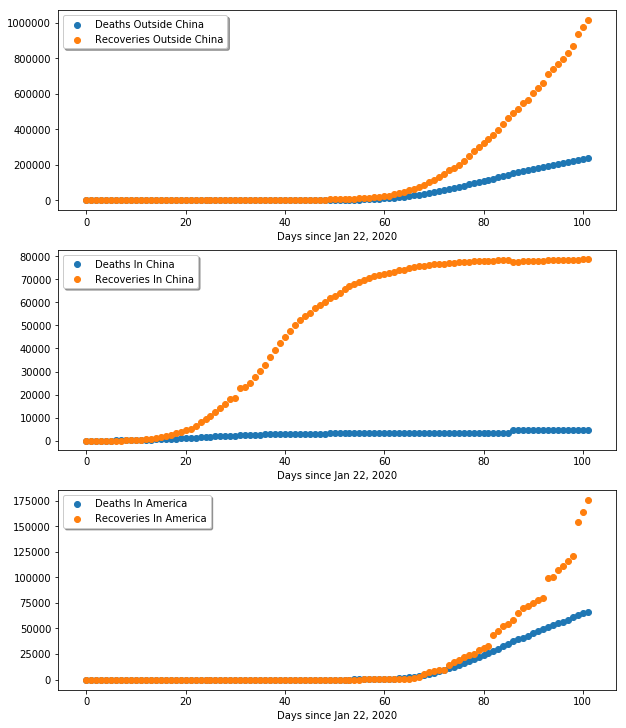

In [8]:
"""
@param date_index number of days since Jan 22, 2020
@returns recoveries/deaths on that date index
"""
def worldwide_rec(date_index):
    recovered = 0
    
    #loop through every country that isnt china and get recoveries
    for key in json_data:
        if (key != 'China'):
            recovered = recovered + json_data[key][date_index]['recovered']
    return recovered

def worldwide_d(date_index):
    deaths = 0
    
    #loop through every country that isnt china and get deaths
    for key in json_data:
        if (key != 'China'):
            deaths = deaths + json_data[key][date_index]['deaths']
    return deaths

"""
@param country location specified
@param date_index number of days since Jan 22, 2020
@returns recoveries/deaths on that date index
"""
def country_rec(country, date_index):
    return json_data[country][date_index]['recovered']

def country_d(country, date_index):
    return json_data[country][date_index]['deaths']

#fill arrays of datapoints
outside_deaths = []
outside_recoveries = []
china_deaths = []
china_recoveries = []
us_deaths = []
us_recoveries = []
for i in range(len(json_data['China'])):
    outside_deaths.append(worldwide_d(i))
    outside_recoveries.append(worldwide_rec(i))
    china_deaths.append(country_d('China', i))
    china_recoveries.append(country_rec('China', i))
    us_deaths.append(country_d('US', i))
    us_recoveries.append(country_rec('US', i))

fig, axs = plt.subplots(3, 1, figsize=(10, 12.5))

axs[0].scatter(range(len(json_data['China'])), outside_deaths, label='Deaths Outside China')
axs[0].scatter(range(len(json_data['China'])), outside_recoveries, label='Recoveries Outside China')
axs[0].set_xlabel('Days since Jan 22, 2020')
axs[0].legend(shadow=True, fancybox=True)

axs[1].scatter(range(len(json_data['China'])), china_deaths, label='Deaths In China')
axs[1].scatter(range(len(json_data['China'])), china_recoveries, label='Recoveries In China')
axs[1].set_xlabel('Days since Jan 22, 2020')
axs[1].legend(shadow=True, fancybox=True)

axs[2].scatter(range(len(json_data['China'])), us_deaths, label='Deaths In America')
axs[2].scatter(range(len(json_data['China'])), us_recoveries, label='Recoveries In America')
axs[2].set_xlabel('Days since Jan 22, 2020')
axs[2].legend(shadow=True, fancybox=True)

This is a big source of confusion as the graphs in each setting all look very different. So we cannot define this certain mortality or recovery rate of the virus. But to get idea of how it changes over time, we'll fit over $\gamma(t)$ and $\delta(t)$ for our three cases. This will be done by calculating:

$$\gamma(t)=\frac{dR}{dt}\div I\approx\frac{R(t)-R(t-1)}{I}$$
$$\delta(t)=\frac{dD}{dt}\div I\approx\frac{D(t)-D(t-1)}{I}$$

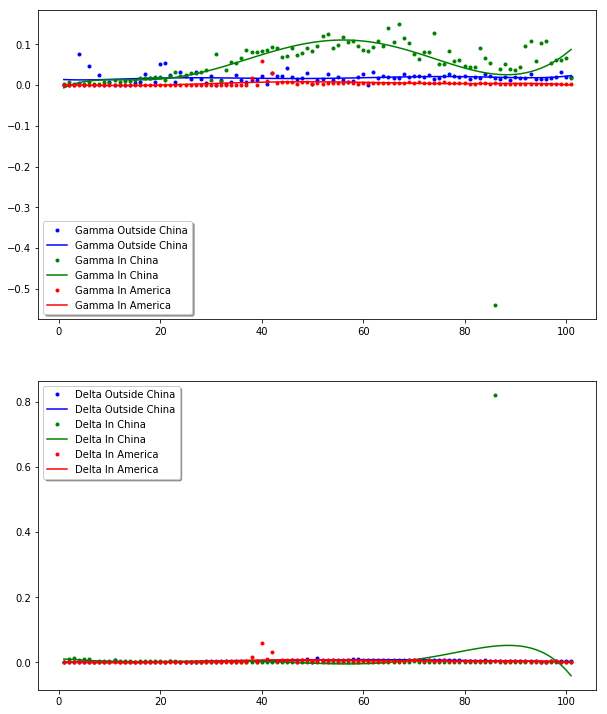

In [9]:
"""
These functions return gamma and delta for outside chin
"""
def worldwide_gamma_2(date_index):
    return (outside_recoveries[date_index]-outside_recoveries[date_index - 1])/currently_infected_outside[date_index]

def worldwide_delta(date_index):
    return (outside_deaths[date_index]-outside_deaths[date_index- 1 ])/currently_infected_outside[date_index]

def china_gamma_2(date_index):
    return (china_recoveries[date_index]-china_recoveries[date_index - 1])/currently_infected_china[date_index]

def china_delta(date_index):
    return (china_deaths[date_index]-china_deaths[date_index - 1])/currently_infected_china[date_index]

def us_gamma_2(date_index):
    return (us_deaths[date_index]-us_deaths[date_index - 1])/currently_infected_us[date_index]

def us_delta(date_index):
    return (us_deaths[date_index]-us_deaths[date_index - 1])/currently_infected_us[date_index]

#arrays to be filled
worldwide_gammas = []
worldwide_deltas = []
china_gammas = []
china_deltas = []
us_gammas = []
us_deltas = []
for i in x_vals:
    worldwide_gammas.append(worldwide_gamma_2(i))
    worldwide_deltas.append(worldwide_delta(i))
    china_gammas.append(china_gamma_2(i))
    china_deltas.append(china_delta(i))
    us_gammas.append(us_gamma_2(i))
    us_deltas.append(us_delta(i))

#6th degree polynomial fit
worldwide_gamma_coeffs = np.polyfit(x_vals, worldwide_gammas, 6)
china_gamma_coeffs = np.polyfit(x_vals, china_gammas, 6)
us_gamma_coeffs = np.polyfit(x_vals, us_gammas, 6)

worldwide_gamma_fit = np.poly1d(worldwide_gamma_coeffs)
china_gamma_fit = np.poly1d(china_gamma_coeffs)
us_gamma_fit = np.poly1d(us_gamma_coeffs)

worldwide_delta_coeffs = np.polyfit(x_vals, worldwide_deltas, 6)
china_delta_coeffs = np.polyfit(x_vals, china_deltas, 6)
us_delta_coeffs = np.polyfit(x_vals, us_deltas, 6)

worldwide_delta_fit = np.poly1d(worldwide_delta_coeffs)
china_delta_fit = np.poly1d(china_delta_coeffs)
us_delta_fit = np.poly1d(us_delta_coeffs)

#plot the data
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))
axs[0].plot(range(1, len(json_data['China'])), worldwide_gammas, '.', x_vals, worldwide_gamma_fit(x_vals), '-', label='Gamma Outside China', color='b')
axs[0].plot(range(1, len(json_data['China'])), china_gammas, '.', x_vals, china_gamma_fit(x_vals), '-', label='Gamma In China', color='g')
axs[0].plot(range(1, len(json_data['China'])), us_gammas, '.', x_vals, us_gamma_fit(x_vals), '-', label='Gamma In America', color='r')
axs[0].legend(shadow=True, fancybox=True)

axs[1].plot(range(1, len(json_data['China'])), worldwide_deltas, '.', x_vals, worldwide_delta_fit(x_vals), '-', label='Delta Outside China', color='b')
axs[1].plot(range(1, len(json_data['China'])), china_deltas, '.', x_vals, china_delta_fit(x_vals), '-', label='Delta In China', color='g')
axs[1].plot(range(1, len(json_data['China'])), us_deltas, '.', x_vals, us_delta_fit(x_vals), '-', label='Delta In America', color='r')
axs[1].legend(shadow=True, fancybox=True)

Now that $\gamma(t)$ and $\delta(t)$ have been approximated, we can now solve for $R,D$. Remembering the system:

$$\frac{dR}{dt}=\gamma I$$
$$\frac{dD}{dt}=\delta I$$

[<matplotlib.lines.Line2D at 0x783b50>, <matplotlib.lines.Line2D at 0x783c70>]

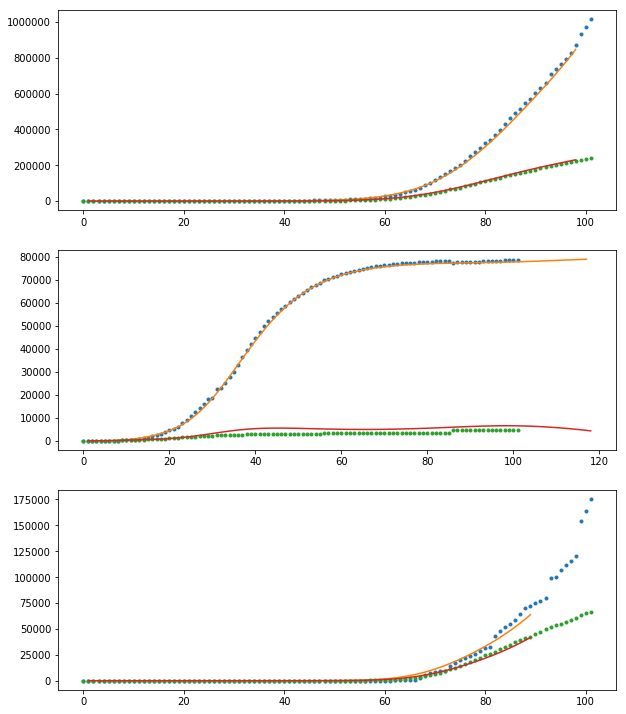

In [11]:
#dydx functions
def world_R(y, t):
    return worldwide_gamma_fit(t)*worldwide_I_fit[int(t)]

def world_D(y, t):
    return worldwide_delta_fit(t)*worldwide_I_fit[int(t)]

def china_R(y, t):
    try:
        return china_gamma_fit(t)*china_I_fit[int(t)]
    except:
        return
        #print(t)

def china_D(y, t):
    #Error to be fixed with Chinese fit...
    try:
        return china_delta_fit(t)*china_I_fit[int(t)]
    except:
        return
        #print(t)
        
def us_R(y, t):
    #Error to be fixed with US fits...
    try:
        return us_gamma_fit(t)*us_I_fit[int(t)]
    except:
        return
        #print(t)

def us_D(y, t):
    try:
        return us_delta_fit(t)*us_I_fit[int(t)]
    except:
        return
        #print(t)

#ICs
world_R_init = worldwide_rec(1)
world_D_init = worldwide_d(1)
china_R_init = country_rec('China', 1)
china_D_init = country_d('China', 1)
us_R_init = country_rec('US', 1)
us_D_init = country_d('US', 1)

#ranges of approximation
world_range = range(1, len(worldwide_I_fit))
china_range = range(1, len(china_I_fit))
us_range = range(1, 90)

#solving the diff eqs
world_R_fit = odeint(world_R, world_R_init, world_range)
world_D_fit = odeint(world_D, world_D_init, world_range)
china_R_fit = odeint(china_R, china_R_init, china_range)
china_D_fit = odeint(china_D, china_D_init, china_range)
us_R_fit = odeint(us_R, us_R_init, us_range)
us_D_fit = odeint(us_D, us_D_init, us_range)

"""corrections in the integration constants"""
#calculate multipliers
world_R_norm = np.linalg.norm(outside_recoveries, 2)
world_Rfit_norm = np.linalg.norm(world_R_fit[:len(outside_recoveries)], 2)
world_R_multiplier = (world_Rfit_norm/world_R_norm)

china_R_norm = np.linalg.norm(china_recoveries, 2)
china_Rfit_norm = np.linalg.norm(china_R_fit[:len(china_recoveries)], 2)
china_R_multiplier = (china_Rfit_norm/china_R_norm)**(-1)

us_R_norm = np.linalg.norm(us_recoveries[:len(us_R_fit)], 2)
us_Rfit_norm = np.linalg.norm(us_R_fit, 2)
us_R_multiplier = us_R_norm/us_Rfit_norm

world_D_norm = np.linalg.norm(outside_deaths, 2)
world_Dfit_norm = np.linalg.norm(world_D_fit[:len(outside_deaths)], 2)
world_D_multiplier = world_Dfit_norm/world_D_norm

china_D_norm = np.linalg.norm(china_deaths, 2)
china_Dfit_norm = np.linalg.norm(china_D_fit[:len(china_deaths)], 2)
china_D_multiplier = china_Dfit_norm/china_D_norm

#print(len(us_D_fit), len(us_deaths))
us_D_norm = np.linalg.norm(us_deaths[:len(us_D_fit)], 2)
us_Dfit_norm = np.linalg.norm(us_D_fit, 2)
us_D_multiplier = us_D_norm/us_Dfit_norm

#multiply the scalars
for i in range(len(world_R_fit)):
    world_R_fit[i] = world_R_fit[i] * world_R_multiplier
    
for i in range(len(china_R_fit)):
    china_R_fit[i] = china_R_fit[i] * china_R_multiplier

for i in range(len(us_R_fit)):
    us_R_fit[i] = us_R_fit[i] * us_R_multiplier
    
for i in range(len(world_D_fit)):
    world_D_fit[i] = world_D_fit[i] * world_D_multiplier
    
for i in range(len(china_D_fit)):
    china_D_fit[i] = china_D_fit[i] * china_D_multiplier

for i in range(len(us_D_fit)):
    us_D_fit[i] = us_D_fit[i] * us_D_multiplier

#Bounds
fig, axs = plt.subplots(3, 1, figsize=(10, 12.5))
axs[0].plot(range(len(json_data['China'])), outside_recoveries, '.', world_range, world_R_fit, '-')
axs[0].plot(range(len(json_data['China'])), outside_deaths, '.', world_range, world_D_fit, '-')

axs[1].plot(range(len(json_data['China'])), china_recoveries, '.', china_range, china_R_fit, '-')
axs[1].plot(range(len(json_data['China'])), china_deaths, '.', china_range, china_D_fit, '-')

axs[2].plot(range(len(json_data['US'])), us_recoveries, '.', us_range, us_R_fit, '-')
axs[2].plot(range(len(json_data['US'])), us_deaths, '.', us_range, us_D_fit, '-')

The next step forward is to keep the graphs of $\delta$, $\gamma$, and $\beta$ in their respective bounds to prevent any blowing up (see Worldwide SIR) or errors in the graph (as marked with the try/except statements).